In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

ibmqfactory.load_account:WARNING:2023-09-04 11:58:16,790: Credentials are already in use. The existing account in the session will be replaced.


In [4]:
h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n)])


def effective_hem(size, J):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        hem[i, i] = h(size, J, Z)
    return hem

In [6]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = 128
#shots = np.arange(10, 2000, 100)
shots = [2 ** i for i in range(7, 12)]
delay = np.linspace(0, 2 * np.pi, measurements)
repetitions = 4
for n in range(2, 6):  #qubits
    shot_list = {}
    median_dist_for_shots = []
    mean_dist_for_shots = []
    std_dist_for_shots = []
    for s in shots:
        rep_list = []
        for rep in range(repetitions):
            J = [random.gauss(1, 0.4) for _ in range(n)]
            delay_list = []
            for t in delay:
                delay_list.append(RamseyExperiment(n, t, s // measurements, J,
                                                   f'J = {J} CosineFit n = {n} shots = {s} rep = {rep} delay = {t}'))
            ramseyBatch = RamseyBatch(delay_list)
            rep_list.append(ramseyBatch)

        median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
        mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
        std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

        shot_list["mean"] = mean_dist_for_shots
        shot_list["std"] = std_dist_for_shots
        shot_list["median"] = median_dist_for_shots

    exp.append(shot_list)


5
5
5


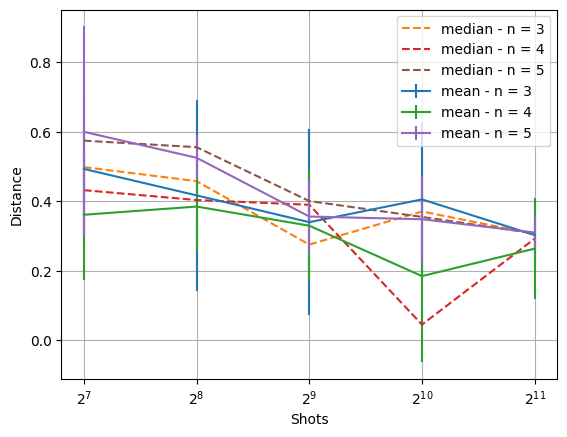

In [7]:
% matplotlib inline

plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
for i in range(1, len(exp)):
    dist = exp[i]
    print(len(dist["mean"]))
    plt.errorbar(shots, dist["mean"], yerr=dist["std"], linestyle='-', label=f'mean - n = {str(i + 2)}')
    plt.plot(shots, dist["median"], linestyle='--', label=f'median - n = {str(i + 2)}')
plt.xscale('log', base=2)
plt.legend()

## 4 Qubits with Varying Number of Measurement Points

In [9]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = [2 ** i for i in range(7, 10)]
shots = [2 ** i for i in range(7, 12)]
#shots = [500]
repetitions = 20
for n in measurements:  #qubits
    shot_list = {}
    median_dist_for_shots = []
    mean_dist_for_shots = []
    std_dist_for_shots = []
    for s in shots:
        rep_list = []
        for rep in range(repetitions):
            J = [random.gauss(1, 0.1) for _ in range(4)]
            delay_list = []
            delay = np.linspace(0, 2 * np.pi, n)
            for t in delay:
                delay_list.append(
                    RamseyExperiment(4, t, s // n, J, f'CosineFit meas = {n} shots = {s} rep = {rep} delay = {t}'))
            ramseyBatch = RamseyBatch(delay_list)
            rep_list.append(ramseyBatch)
        median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
        mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
        std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

        shot_list["mean"] = mean_dist_for_shots
        shot_list["std"] = std_dist_for_shots
        shot_list["median"] = median_dist_for_shots

    exp.append(shot_list)



QiskitError: 'No counts for experiment "0"'

In [ ]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
for i in range(1, len(exp)):
    dist = exp[i]
    plt.errorbar(shots, dist["mean"], yerr=dist["std"], linestyle='-',
                 label=f'mean - measurement points = {str(measurements[i])}')
    plt.plot(shots, dist["median"], linestyle='--', label=f'median - measurement points = {str(measurements[i])}')
plt.xscale('log', base=2)
plt.legend()

## 4 Qubits with Varying Number of Measurement Points and fixed number of shots

In [11]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = [2 ** i for i in range(4, 10)]
shots = 2048
repetitions = 20
shot_list = {}
median_dist_for_shots = []
mean_dist_for_shots = []
std_dist_for_shots = []
for n in measurements:  #qubits

    rep_list = []
    for rep in range(repetitions):
        J = [random.gauss(1, 0.1) for _ in range(4)]
        delay_list = []
        delay = np.linspace(0, 2 * np.pi, n)
        for t in delay:
            delay_list.append(
                RamseyExperiment(4, t, shots // n, J, f'CosineFit meas = {n} shots = {s} rep = {rep} delay = {t}'))
        ramseyBatch = RamseyBatch(delay_list)
        rep_list.append(ramseyBatch)
    median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
    mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
    std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

shot_list["mean"] = mean_dist_for_shots
shot_list["std"] = std_dist_for_shots
shot_list["median"] = median_dist_for_shots

exp.append(shot_list)



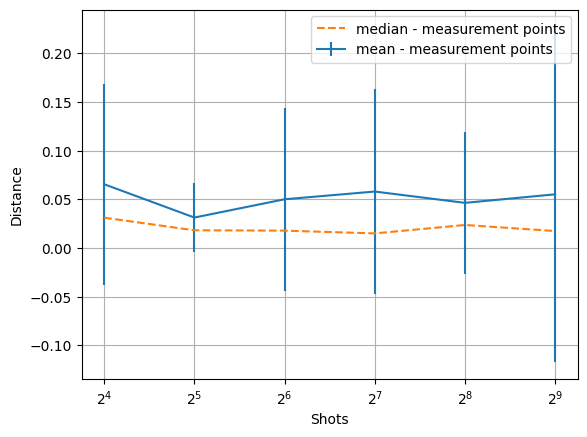

In [12]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
dist = shot_list
plt.errorbar(measurements, dist["mean"], yerr=dist["std"], linestyle='-', label=f'mean - measurement points')
plt.plot(measurements, dist["median"], linestyle='--', label=f'median - measurement points')

plt.xscale('log', base=2)
plt.legend()

ibmqfactory.load_account:WARNING:2023-09-05 17:08:23,535: Credentials are already in use. The existing account in the session will be replaced.


[1.0974117827660717, 0.9720132399375693, 0.9004159165864898, 1.3724891606682215, 0.3795014373677179, 0.7306909802664019]
FFT:  [1.3725285  0.90046439 0.97197612 1.09733764 0.73068842 0.37946855]
No FFT:  [1.09355147 1.16249753 0.91214124 0.84538798 0.88680583 1.11800606]


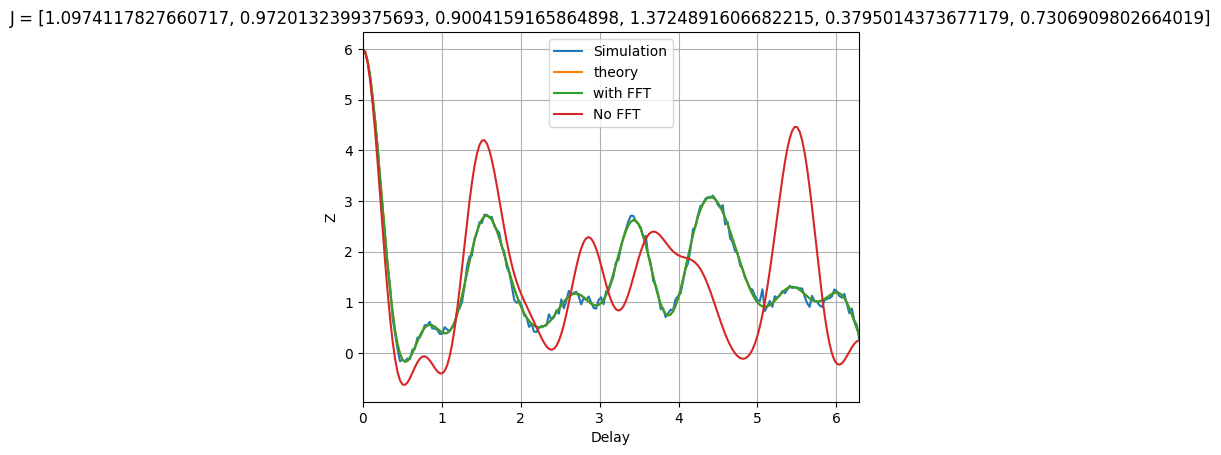

In [121]:
from scipy.optimize import curve_fit
import random
import importlib
import ramsey_experiment

ramsey_experiment = importlib.reload(ramsey_experiment)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

n = 6


def func(t, js):
    n = len(js)
    result = 2 * n
    for i in range(n):
        result += 4 * np.cos(4 * js[i] * t)
    for i in range(n):
        result += 2 * np.cos(4 * (js[i] + js[(i + 1) % n]) * t)
    return result / (2 ** (n - (n - 3)))


J = [random.gauss(1, 0.3) for _ in range(n)]
print(J)
#J = [1.1427127635933145, 0.6618471551098581, 0.7950166929006339, 0.3950166929006339]
delay_list = []
exp = []
measurements = 1000
delay = np.linspace(0, 10 * np.pi, measurements)
for t in delay:
    delay_list.append(RamseyExperiment(n, t, 1000, J, "4"))
ramseyBatch1 = RamseyBatch(delay_list)
ramseyBatch2 = RamseyBatch(delay_list)

J_fit_fft = ramseyBatch1.curve_fit(use_fft=True)
J_fit_no_fft = ramseyBatch2.curve_fit(use_fft=False)
print("FFT: " , J_fit_fft)
print("No FFT: ", J_fit_no_fft)
#print(ramseyBatch.Z)
plt.grid()
plt.ylabel('Z')
plt.xlabel('Delay')
plt.title(f'J = {J}')
plt.plot(delay, ramseyBatch1.Z, label='Simulation')
plt.plot(delay, [func(t, J) for t in delay], label='theory')

plt.plot(delay, [func(t, J_fit_fft) for t in delay], label='with FFT')
plt.plot(delay, [func(t, J_fit_no_fft) for t in delay], label='No FFT')

plt.xlim(0,2*np.pi)
plt.legend()

Frequency: 0.25464790894703254, Magnitude: 471.9038820398366
Frequency: 0.5092958178940651, Magnitude: 438.2935728255552
Frequency: 0.7321127382227186, Magnitude: 400.82894229578636
Frequency: 0.4297183463481174, Magnitude: 322.6340988681382


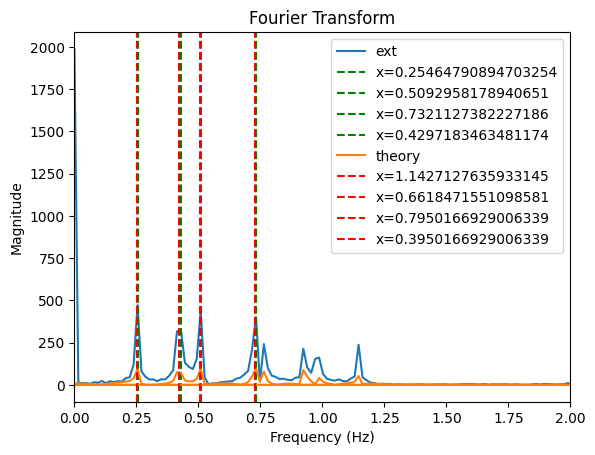

In [109]:
from scipy.signal import find_peaks
%matplotlib inline
w_ = 1000
def fo(w, js):
    n = len(js)
    result = 0
    for i in range(n):
        #result += (np.sqrt(2/np.pi) * np.sin(10 * np.pi * (4 * js[i] + w))) / (4 * js[i] + w)


        result += 2*(np.sqrt(2/np.pi) * np.sin(w_ * np.pi * (2 * js[i]/np.pi + w))) / (2 * js[i]/np.pi + w)
        result += 2*(np.sqrt(2/np.pi) * np.sin(w_ * np.pi * (2 * js[i]/np.pi - w))) / (2 * js[i]/np.pi - w)

        result += (np.sin(w_ * np.pi * (2 * (js[i] + js[(i + 1) % n])/np.pi + w)))/(np.sqrt(2/np.pi) * (2 * (js[i] + js[(i + 1) % n])/np.pi + w))
        result += (np.sin(w_ * np.pi * (2 * (js[i] + js[(i + 1) % n])/np.pi - w)))/(np.sqrt(2/np.pi) * (2 * (js[i] + js[(i + 1) % n])/np.pi - w))

    #result += (3 * np.sqrt(2/np.pi) * np.sin(10 * np.pi * w)) / w
    #result = result/ (2 ** (n - (n - 3)))
    return 3*result/(2 ** (n - (n - 3)))

extended = ramseyBatch1.Z[::-1]
extended = extended + ramseyBatch1.Z
fft_output_ext = np.fft.fft(extended)
fft_output = np.fft.fft(ramseyBatch1.Z)

# Compute the corresponding frequencies
sample_rate = measurements / (10 * np.pi)  # Sampling rate of your data (change if known)
frequencies_ext = np.fft.fftfreq(2 * len(ramseyBatch1.Z), 1 / sample_rate)
frequencies = np.fft.fftfreq( len(ramseyBatch1.Z), 1 / sample_rate)

plt.plot(frequencies_ext, np.abs(fft_output_ext), label= "ext")
#plt.plot(frequencies, np.abs(fft_output), label= "org")


positive_indices = np.where(frequencies_ext > 0)
positive_magnitudes = np.abs(fft_output_ext)[positive_indices]
peaks, _ = find_peaks(positive_magnitudes)

# Get the magnitudes of these peaks
peak_magnitudes = positive_magnitudes[peaks]

# Sort the peaks by their magnitudes in descending order
sorted_peak_indices = np.argsort(peak_magnitudes)[::-1]

# Choose the n highest peaks
n_highest_peaks = sorted_peak_indices[:n]  # Choose a value for n

# Print the x (frequency) values of the n highest peaks
for peak_index in n_highest_peaks:
    val = frequencies_ext[positive_indices][peaks[peak_index]]
    print(f"Frequency: {frequencies_ext[positive_indices][peaks[peak_index]]}, Magnitude: {peak_magnitudes[peak_index]}")
    plt.axvline(x=val, color='green', linestyle='--', label=f'x={val}')


plt.plot(frequencies_ext, np.abs([fo(t, J) for t in frequencies_ext]), label='theory')

for val in J:
    plt.axvline(x=val/(0.5*np.pi), color='red', linestyle='--', label=f'x={val}')



plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 2)
#plt.ylim(0,400)
plt.legend()
plt.show()